# Analysis of LIGO/Virgo strain data

## GW170814

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import json
import h5py
from pathlib import Path

from scipy.signal import tukey

from gwpy.timeseries import TimeSeries
import gwosc
import pycbc.psd

### Obtain data

Use gwpy to download the data for GW150914. Consider only the "H1" data for now; "L1" should be treated similarly.

In [2]:
t_event = gwosc.datasets.event_gps('GW170814')
t_event = gwosc.datasets.event_gps('GW150914')
# t_event = 1187008882.4  # GPS time of coalescence
print(t_event)

T = 8.0  # number of seconds to analyze in a segment
T_psd = 1024.0  # number of seconds of data for estimating PSD
T_buffer = 2.0  # buffer time after the event to include

1126259462.4


In [3]:
h1_event = TimeSeries.fetch_open_data(
    'H1',
    t_event + T_buffer - T,
    t_event + T_buffer,
    cache=True
)

# To calculate the PSD, take data before the event segment
h1_psd = TimeSeries.fetch_open_data(
    'H1',
    t_event + T_buffer - T - T_psd,
    t_event + T_buffer - T,
    cache=True
)

In [4]:
# Check sampling frequency
f_s = len(h1_event)/T
f_s

4096.0

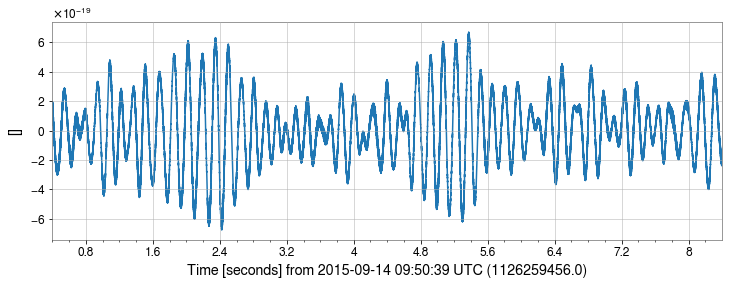

In [5]:
plot = h1_event.plot()
plt.show()

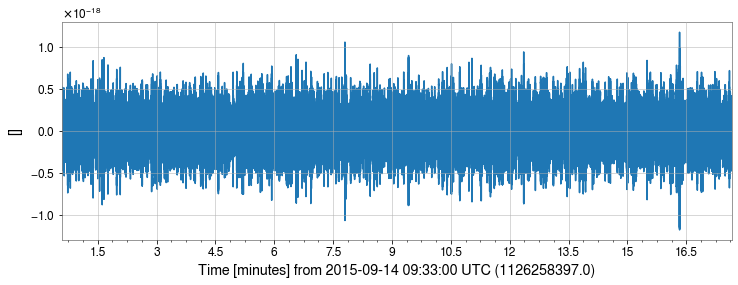

In [6]:
plot = h1_psd.plot()
plt.show()

Convert to pycbc TimeSeries objects.

In [7]:
h1_event = h1_event.to_pycbc()
h1_psd = h1_psd.to_pycbc()

### PSD

We use the "welch" method. Default settings for this method are to use a Hann window, and in each frequency bin to take the median over all segments. However, we will use a Tukey window, with 0.4 s roll-off, and no overlap, as is described in the LALInference paper (https://arxiv.org/abs/1409.7215).

#### Window function

This window will be used both for PSD estimation and for the event segment.

In [8]:
roll_off = 0.4
alpha = 2 * roll_off / T

w = tukey(int(T * f_s), alpha)

In [11]:
w.shape

(32768,)

In [12]:
h1_event.sample_times.data.shape

(32768,)

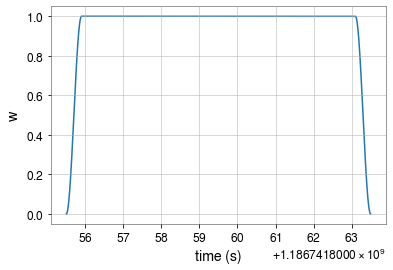

In [9]:
plt.plot(h1_event.sample_times, w)
plt.xlabel('time (s)')
plt.ylabel('w')
plt.show()

#### PSD estimation

In [14]:
# psd = pycbc.psd.estimate.welch(h1_psd, seg_len=int(T * f_s), seg_stride=int(T * f_s / 2), window='hann', avg_method='median')
psd = pycbc.psd.estimate.welch(h1_psd, seg_len=int(T * f_s), seg_stride=int(T * f_s), window=w, avg_method='median')

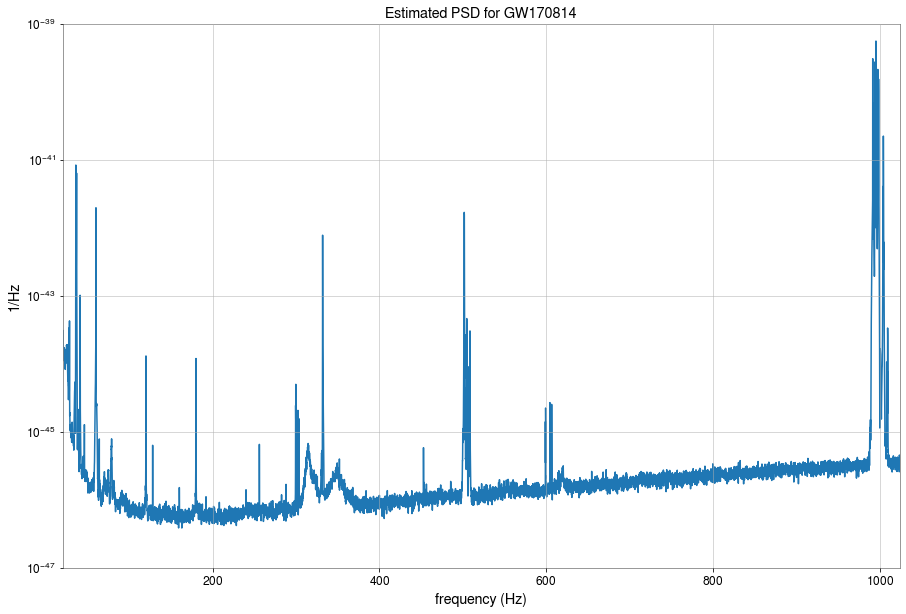

In [15]:
plt.figure(figsize=(15,10))
plt.plot(psd.sample_frequencies, psd)
plt.yscale('log')
plt.xlabel('frequency (Hz)')
plt.ylabel('1/Hz')
plt.title('Estimated PSD for GW170814')
plt.xlim((20,1024))
plt.ylim((1e-47, 1e-39))
plt.show()

#### Aside: BayesWave PSD

For comparison to estimated PSD.

In [18]:
# I downloaded this data file from GWOSC
psd_bayeswave = np.loadtxt('../data/psds/GWTC1_GW170814_PSDs.dat.txt')

# Add a final point at 1024 Hz
psd_bayeswave = np.append(psd_bayeswave, np.reshape(psd_bayeswave[-1], (1,3)), axis=0)
psd_bayeswave[-1,0] = 1024.0

OSError: ../data/psds/GWTC1_GW170817_PSDs.dat.txt not found.

In [40]:
psd_bayeswave = pycbc.psd.from_numpy_arrays(psd_bayeswave[:,0], psd_bayeswave[:,1], 8193, 1/8, 20.0)

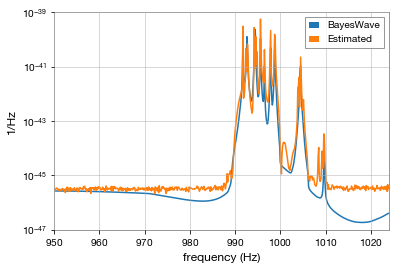

In [153]:
#plt.figure(figsize=(15,11))
plt.plot(psd_bayeswave.sample_frequencies, psd_bayeswave, label='BayesWave')
plt.plot(psd.sample_frequencies, psd, label='Estimated')
plt.yscale('log')
plt.xlim((950,1024))
plt.ylim((1e-47, 1e-39))
plt.legend()
plt.xlabel('frequency (Hz)')
plt.ylabel('1/Hz')
plt.show()

The BayesWave PSD has a weird dip just after 1000 Hz. I think this is an effect of using a spline to fit the big jump at slightly lower frequencies. This gives a whitened waveform that has a lot of extra power just beyond 1000 Hz, so I will use the PSD estimated using the welch method.

### Event

Window the 8 s segment that contains the event, take the FFT, and scale by the inverse ASD.

In [12]:
h1_event_FD = (h1_event * w).to_frequencyseries()
h1_event_FD_whitened = h1_event_FD / psd ** 0.5

In [13]:
h1_event_FD_whitened.data[1000]

(3.047696537920332-1.413543451209079j)

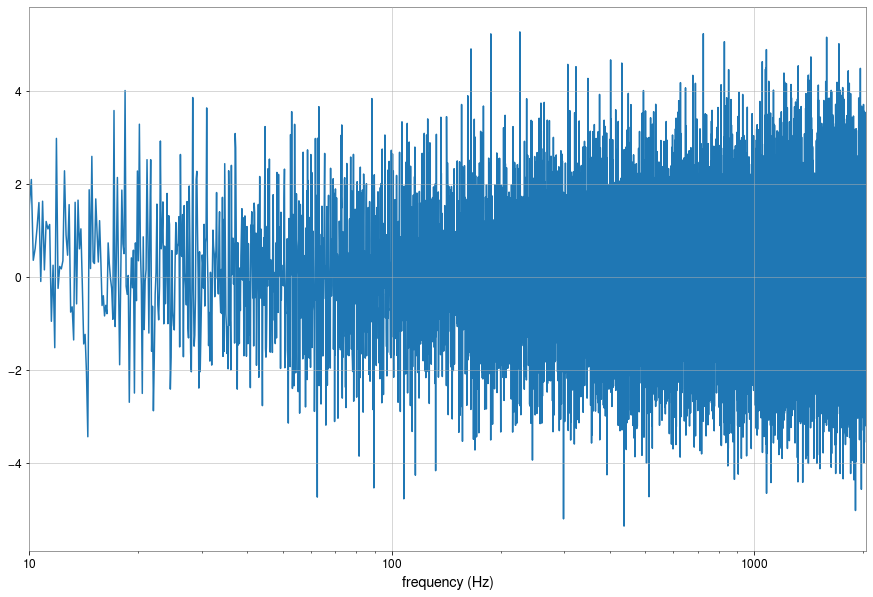

In [14]:
plt.figure(figsize=(15,10))
plt.plot(h1_event_FD_whitened.sample_frequencies, h1_event_FD_whitened.real())
plt.xlabel('frequency (Hz)')
#plt.xlim((995,1005))
plt.xscale('log')
plt.xlim((10,2048))
plt.show()

Zero below 20 Hz and truncate above 1024 Hz. This is all that is needed for the likelihood integral.

In [15]:
f_min = 20.0
f_max = 1024.0  # New f_max. Previously it was 2048 Hz.

h1_event_FD_whitened[:int(f_min / h1_event_FD_whitened.delta_f)] = 0.0
h1_event_FD_whitened = h1_event_FD_whitened[:int(f_max / h1_event_FD_whitened.delta_f)+1]

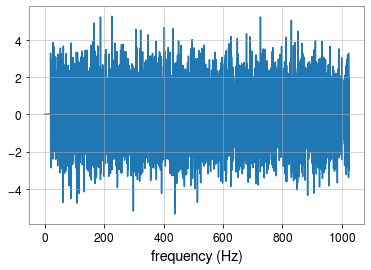

In [16]:
plt.plot(h1_event_FD_whitened.sample_frequencies, h1_event_FD_whitened.real())
plt.xlabel('frequency (Hz)')
plt.show()

Apply a time shift to shift the merger to $t=0$. This should make the event visible in the Fourier transform.

In [17]:
h1_event_FD_whitened = h1_event_FD_whitened.cyclic_time_shift(T_buffer)

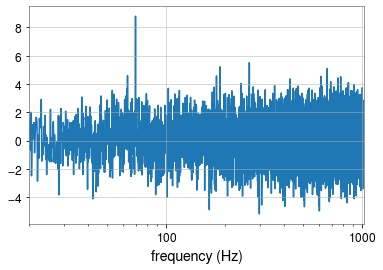

In [18]:
plt.plot(h1_event_FD_whitened.sample_frequencies, h1_event_FD_whitened.real())
plt.xlabel('frequency (Hz)')
plt.xscale('log')
plt.xlim((20,1024))
plt.show()

#### Normalization

The noise is not quite normalized to unit variance in the real and imaginary parts.

In [19]:
# Compute the variance of the real part of the whitened FD strain data.

np.var(h1_event_FD_whitened.numpy().real)

1.895757453644065

There are two issues here:

* We need to account for $\delta f$ for the DFT, the 1-sided PSD, and the real and imaginary parts.
* We need to account for the window function that we used. This requires multiplication by a "window factor." Since the signal is much shorter than $T$, the windowing only affects the amount of noise in the data, not the signal.

In [20]:
delta_f = h1_event_FD_whitened.delta_f

normalization_1 = 1 / np.sqrt(4 * delta_f)
window_factor = np.sum(w ** 2) / (T * f_s)

normalization = normalization_1 * np.sqrt(window_factor)

In [21]:
normalization ** 2

1.874942779543568

They match, more or less.

In [22]:
normalized_FD = h1_event_FD_whitened.numpy() / normalization

In [23]:
print(np.var(normalized_FD.real), np.var(normalized_FD.imag))

1.0111014983110918 1.0045112012883435


The point of this is that when we train our network, we need to generate noise, which is added to whitened waveforms. Ultimately we plan to evaluate the network on the whitened event strain data, which has been windowed before FFTing, as above. Thus the noise that is added during training should have a standard deviation given by `normalization` in each of the real and imaginary parts.

### Save PSD to file

In [24]:
event_dir = Path('../data/events/GW170814')
event_dir.mkdir(parents=True, exist_ok=True)

psd.save(event_dir / 'PSD_H1.txt')

## L1 detector

Do the same calculation, save to file.

In [25]:
l1_psd_data = TimeSeries.fetch_open_data(
    'L1',
    t_event + T_buffer - T - T_psd,
    t_event + T_buffer - T,
    cache=True
)
l1_psd_data = l1_psd_data.to_pycbc()
l1_psd = pycbc.psd.estimate.welch(
    l1_psd_data,
    seg_len=int(T * f_s),
    seg_stride=int(T * f_s),
    window=w,
    avg_method='median'
)

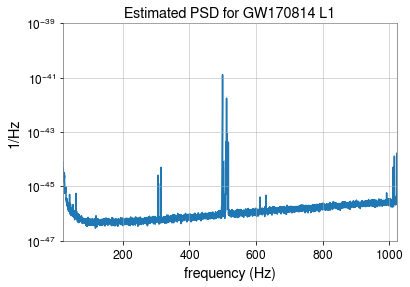

In [26]:
plt.plot(l1_psd.sample_frequencies, l1_psd)
plt.yscale('log')
plt.xlabel('frequency (Hz)')
plt.ylabel('1/Hz')
plt.title('Estimated PSD for GW170814 L1')
plt.xlim((20,1024))
plt.ylim((1e-47, 1e-39))
plt.show()

In [27]:
l1_event_data = TimeSeries.fetch_open_data(
    'L1',
    t_event + T_buffer - T,
    t_event + T_buffer,
    cache=True
)
l1_event_data = l1_event_data.to_pycbc()

In [28]:
l1_event_FD = (l1_event_data * w).to_frequencyseries()
l1_event_FD_whitened = l1_event_FD / l1_psd ** 0.5

l1_event_FD_whitened[:int(f_min / delta_f)] = 0.0
l1_event_FD_whitened = l1_event_FD_whitened[:int(f_max / delta_f)+1]

l1_event_FD_whitened = l1_event_FD_whitened.cyclic_time_shift(T_buffer)

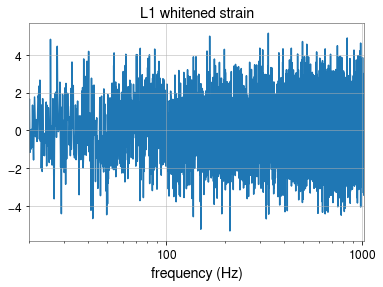

In [29]:
plt.plot(l1_event_FD_whitened.sample_frequencies, l1_event_FD_whitened.real())
plt.xlabel('frequency (Hz)')
plt.xscale('log')
plt.xlim((20,1024))
plt.title('L1 whitened strain')
plt.show()

Compare H1 and L1 PSDs

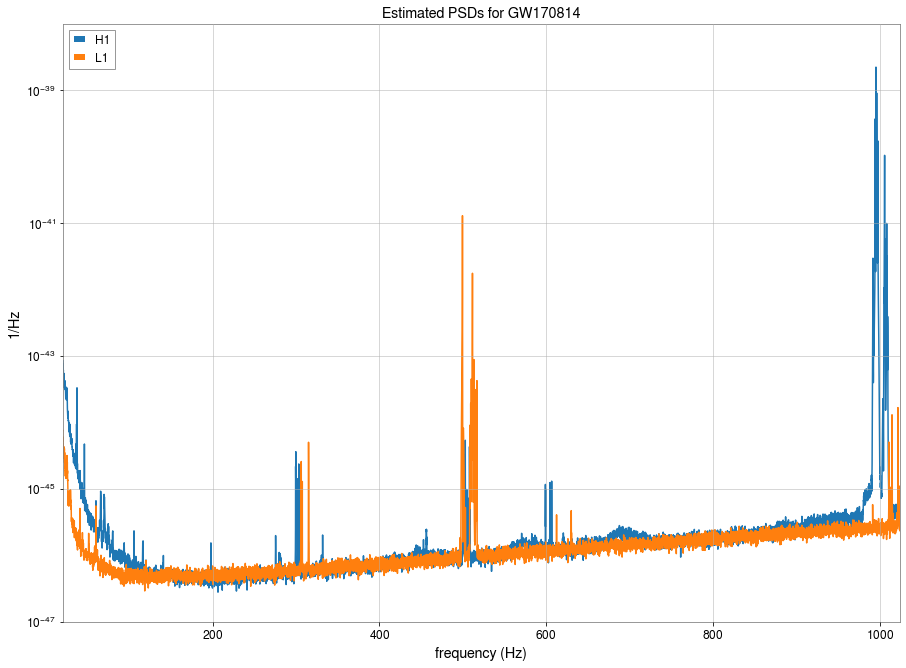

In [30]:
plt.figure(figsize=(15,11))
plt.plot(psd.sample_frequencies, psd, label='H1')
plt.plot(l1_psd.sample_frequencies, l1_psd, label='L1')
plt.yscale('log')
plt.xlabel('frequency (Hz)')
plt.ylabel('1/Hz')
plt.title('Estimated PSDs for GW170814')
plt.xlim((20,1024))
plt.ylim((1e-47, 1e-38))
plt.legend()
plt.show()

These PSDs have a fair bit more structure than the design sensitivity PSDs. Since we train our reduced basis to represent whitened waveforms, this may mean we need more basis elements to obtain a good representation.

In [31]:
l1_psd.save(event_dir / 'PSD_L1.txt')

### Save

In [32]:
# Whitened FD strain data
h1_event_fd_whitened_numpy = np.array(h1_event_FD_whitened.sample_frequencies.numpy())
with h5py.File(event_dir / 'strain_FD_whitened.hdf5', 'w') as f:
    f.create_dataset('sample_frequencies', data=h1_event_fd_whitened_numpy)
    f.create_dataset('H1', data=h1_event_FD_whitened)
    f.create_dataset('L1', data=l1_event_FD_whitened)

In [35]:
# Additional information

with open(event_dir / 'event_info.json', 'w') as f:
    json.dump(dict(
        event='GW170814',
        detectors=['H1', 'L1'],
        t_event=t_event,
        f_min=f_min,
        f_max=f_max,
        T=T,
        T_psd=T_psd,
        T_buffer=T_buffer,
        window_factor=window_factor,
        window='tukey',
        roll_off=roll_off
        ), f, indent=4)

In [34]:
1

1